# Notebook 13: Using Deep Learning to Study SUSY with Pytorch

## Learning Goals
The goal of this notebook is to introduce the powerful PyTorch framework for building neural networks and use it to analyze the SUSY dataset. After this notebook, the reader should understand the mechanics of PyTorch and how to construct DNNs using this package. In addition, the reader is encouraged to explore the GPU backend available in Pytorch on this dataset.

## Overview
In this notebook, we use Deep Neural Networks to classify the supersymmetry dataset, first introduced by Baldi et al. in [Nature Communication (2015)](https://www.nature.com/articles/ncomms5308). The SUSY data set consists of 5,000,000 Monte-Carlo samples of supersymmetric and non-supersymmetric collisions with $18$ features. The signal process is the production of electrically-charged supersymmetric particles which decay to $W$ bosons and an electrically-neutral supersymmetric particle that is invisible to the detector.

The first $8$ features are "raw" kinematic features that can be directly measured from collisions. The final $10$ features are "hand constructed" features that have been chosen using physical knowledge and are known to be important in distinguishing supersymmetric and non-supersymmetric collision events. More specifically, they are given by the column names below.

In this notebook, we study this dataset using Pytorch.

In [2]:
from __future__ import print_function, division
import os,sys
import numpy as np
import torch # pytorch package, allows using GPUs
# fix seed
seed=17
np.random.seed(seed)
torch.manual_seed(seed)

## Structure of the Procedure

Constructing a Deep Neural Network to solve ML problems is a multiple-stage process. Quite generally, one can identify the key steps as follows:

* ***step 1:*** Load and process the data
* ***step 2:*** Define the model and its architecture
* ***step 3:*** Choose the optimizer and the cost function
* ***step 4:*** Train the model 
* ***step 5:*** Evaluate the model performance on the *unseen* test data
* ***step 6:*** Modify the hyperparameters to optimize performance for the specific data set

Below, we sometimes combine some of these steps together for convenience.

Notice that we take a rather different approach, compared to the simpler MNIST Keras notebook. We first define a set of classes and functions and run the actual computation only in the very end.

### Step 1: Load and Process the SUSY Dataset

The supersymmetry dataset can be downloaded from the UCI Machine Learning repository on [https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz](https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz). The dataset is quite large. Download the dataset and unzip it in a directory.

Loading data in Pytroch is done by creating a user-defined a class, which we name `SUSY_Dataset`, and is a child of the `torch.utils.data.Dataset` class. This ensures that all necessary attributes required for the processing of the data during the training and test stages are easily inherited. The `__init__` method of our custom data class should contain the usual code for loading the data, which is problem-specific, and has been discussed for the SUSY data set in Notebook 5. More importantly, the user-defined data class must override the `__len__` and `__getitem__` methods of the parent `DataSet` class. The former returns the size of the data set, while the latter allows the user to access a particular data point from the set by specifying its index.

In [3]:
from torchvision import datasets # load data

class SUSY_Dataset(torch.utils.data.Dataset):
    """SUSY pytorch dataset."""

    def __init__(self, data_file, root_dir, dataset_size, train=True, transform=None, high_level_feats=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            train (bool, optional): If set to `True` load training data.
            transform (callable, optional): Optional transform to be applied on a sample.
            high_level_festures (bool, optional): If set to `True`, working with high-level features only. 
                                        If set to `False`, working with low-level features only.
                                        Default is `None`: working with all features
        """

        import pandas as pd

        features=['SUSY','lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 
                'missing energy magnitude', 'missing energy phi', 'MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2', 
                'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']

        low_features=['lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 
                'missing energy magnitude', 'missing energy phi']

        high_features=['MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2','S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']


        #Number of datapoints to work with
        df = pd.read_csv(root_dir+data_file, header=None,nrows=dataset_size,engine='python')
        df.columns=features
        Y = df['SUSY']
        X = df[[col for col in df.columns if col!="SUSY"]]

        # set training and test data size
        train_size=int(0.8*dataset_size)
        self.train=train

        if self.train:
            X=X[:train_size]
            Y=Y[:train_size]
            print("Training on {} examples".format(train_size))
        else:
            X=X[train_size:]
            Y=Y[train_size:]
            print("Testing on {} examples".format(dataset_size-train_size))


        self.root_dir = root_dir
        self.transform = transform

        # make datasets using only the 8 low-level features and 10 high-level features
        if high_level_feats is None:
            self.data=(X.values.astype(np.float32),Y.values.astype(int))
            print("Using both high and low level features")
        elif high_level_feats is True:
            self.data=(X[high_features].values.astype(np.float32),Y.values.astype(int))
            print("Using both high-level features only.")
        elif high_level_feats is False:
            self.data=(X[low_features].values.astype(np.float32),Y.values.astype(int))
            print("Using both low-level features only.")


    # override __len__ and __getitem__ of the Dataset() class

    def __len__(self):
        return len(self.data[1])

    def __getitem__(self, idx):

        sample=(self.data[0][idx,...],self.data[1][idx])

        if self.transform:
            sample=self.transform(sample)

        return sample

Last, we define a helper function `load_data()` that accepts as a required argument the set of parameters `args`, and returns two generators: `test_loader` and `train_loader` which readily return mini-batches.

In [4]:
def load_data(args):

    data_file='SUSY.csv'
    root_dir=os.path.expanduser('~')+'/Desktop/Fall2019/HW895/PY895/'

    kwargs = {} # CUDA arguments, if enabled
    # load and noralise train and test data
    train_loader = torch.utils.data.DataLoader(
        SUSY_Dataset(data_file,root_dir,args.dataset_size,train=True,high_level_feats=args.high_level_feats),
        batch_size=args.batch_size, shuffle=True, **kwargs)

    test_loader = torch.utils.data.DataLoader(
        SUSY_Dataset(data_file,root_dir,args.dataset_size,train=False,high_level_feats=args.high_level_feats),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    return train_loader, test_loader

### Step 2: Define the Neural Net and its Architecture

To construct neural networks with Pytorch, we make another class called `model` as a child of Pytorch's `nn.Module` class. The `model` class initializes the types of layers needed for the deep neural net in its `__init__` method, while the DNN is assembled in a function method called `forward`, which accepts an `autograd.Variable` object and returns the output layer. Using this convention Pytorch will automatically recognize the structure of the DNN, and the `autograd` module will pull the gradients forward and backward using backprop.

Our code below is constructed in such a way that one can choose whether to use the high-level and low-level features separately and altogether. This choice determines the size of the fully-connected input layer `fc1`. Therefore the `__init__` method accepts the optional argument `high_level_feats`. 

In [53]:
import torch.nn as nn # construct NN

class model(nn.Module):
    def __init__(self,high_level_feats=None):
        # inherit attributes and methods of nn.Module
        super(model, self).__init__()

        # an affine operation: y = Wx + b
        if high_level_feats is None:
            self.fc1 = nn.Linear(18, 200) # all features
        elif high_level_feats:
            self.fc1 = nn.Linear(10, 200) # low-level only
        else:
            self.fc1 = nn.Linear(8, 200) # high-level only


        self.batchnorm1=nn.BatchNorm1d(200, eps=1e-05, momentum=0.1)
        self.batchnorm2=nn.BatchNorm1d(100, eps=1e-05, momentum=0.1)
        
        self.batchnorm3=nn.BatchNorm1d(100, eps=1e-05, momentum=0.2)
        
        self.fc2 = nn.Linear(200, 150) # see forward function for dimensions
        self.fcnew = nn.Linear(150, 100)
        self.fc3 = nn.Linear(100, 2)

    def forward(self, x):
        '''Defines the feed-forward function for the NN.

        A backward function is automatically defined using `torch.autograd`

        Parameters
        ----------
        x : autograd.Tensor
            input data

        Returns
        -------
        autograd.Tensor
            output layer of NN

        '''

        # apply rectified linear unit
        x = F.relu(self.fc1(x))
        # apply dropout
        x=self.batchnorm1(x)
        #x = F.dropout(x, training=self.training)


        # apply rectified linear unit
        x = F.leaky_relu(self.fc2(x))
        # apply dropout
        #x=self.batchnorm2(x)
        x = F.dropout(x, training=self.training)

        x = F.leaky_relu(self.fcnew(x))
        x = self.batchnorm3(x)
        
        # apply affine operation fc2
        x = self.fc3(x)
        # soft-max layer
        x = F.log_softmax(x,dim=1)

        return x

### Steps 3+4+5: Choose the Optimizer and the Cost Function. Train and Evaluate the Model

Next, we define the function `evaluate_model`. The first argument, `args`, contains all hyperparameters needed for the DNN (see below). The second and third arguments are the `train_loader` and the `test_loader` objects, returned by the function `load_data()` we defined in Step 1 above. The `evaluate_model` function returns the final `test_loss` and `test_accuracy` of the model.

First, we initialize a `model` and call the object `DNN`. In order to define the loss function and the optimizer, we use modules `torch.nn.functional` (imported here as `F`) and `torch.optim`. As a loss function we choose the negative log-likelihood, and stored is under the variable `criterion`. As usual, we can choose any from a variety of different SGD-based optimizers, but we focus on the traditional SGD.

Next, we define two functions: `train()` and `test()`. They are called at the end of `evaluate_model` where we loop over the training epochs to train and test our model. 

The `train` function accepts an integer called `epoch`, which is only used to print the training data. We first set the `DNN` in a train mode using the `train()` method inherited from `nn.Module`. Then we loop over the mini-batches in `train_loader`. We cast the data as pytorch `Variable`, re-set the `optimizer`, perform the forward step by calling the `DNN` model on the `data` and computing the `loss`. The backprop algorithm is then easily done using the `backward()` method of the loss function `criterion`. We use `optimizer.step` to update the weights of the `DNN`. Last print the performance for every minibatch. `train` returns the loss on the data.

The `test` function is similar to `train` but its purpose is to test the performance of a trained model. Once we set the `DNN` model in `eval()` mode, the following steps are similar to those in `train`. We then compute the `test_loss` and the number of `correct` predictions, print the results and return them.  

In [54]:
import torch.nn.functional as F # implements forward and backward definitions of an autograd operation
import torch.optim as optim # different update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc

def evaluate_model(args,train_loader,test_loader):

    # create model
    DNN = model(high_level_feats=args.high_level_feats)
    # negative log-likelihood (nll) loss for training: takes class labels NOT one-hot vectors!
    criterion = F.nll_loss
    # define SGD optimizer
    optimizer = optim.SGD(DNN.parameters(), lr=args.lr, momentum=args.momentum)
    #optimizer = optim.Adam(DNN.parameters(), lr=0.001, betas=(0.9, 0.999))


    ################################################

    def train(epoch):
        '''Trains a NN using minibatches.

        Parameters
        ----------
        epoch : int
            Training epoch number.

        '''

        # set model to training mode (affects Dropout and BatchNorm)
        DNN.train()
        # loop over training data
        for batch_idx, (data, label) in enumerate(train_loader):
            # zero gradient buffers
            optimizer.zero_grad()
            # convert labels to continuous "longs"
            label = label.type(torch.LongTensor)
            # compute output of final layer: forward step
            output = DNN(data)
            # compute loss
            loss = criterion(output, label)
            # run backprop: backward step
            loss.backward()
            # update weigths of NN
            optimizer.step()
            
            # print loss at current epoch
            if batch_idx % args.log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item() ))
            

        return loss.item()

    ################################################

    def test():
        '''Tests NN performance.

        '''

        # evaluate model
        DNN.eval()

        test_loss = 0 # loss function on test data
        correct = 0 # number of correct predictions
        # loop over test data
        for data, label in test_loader:
            # compute model prediction softmax probability
            output = DNN(data)
            # compute test loss
            label = label.type(torch.LongTensor)
            test_loss += criterion(output, label, size_average=False).item() # sum up batch loss
            # find most likely prediction
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            # update number of correct predictions
            correct += pred.eq(label.data.view_as(pred)).cpu().sum().item()

        # print test loss
        test_loss /= len(test_loader.dataset)
        
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
        

        return test_loss, correct / len(test_loader.dataset)


    ################################################


    train_loss=np.zeros((args.epochs,))
    test_loss=np.zeros_like(train_loss)
    test_accuracy=np.zeros_like(train_loss)

    epochs=range(1, args.epochs + 1)
    for epoch in epochs:

        train_loss[epoch-1] = train(epoch)
        test_loss[epoch-1], test_accuracy[epoch-1] = test()



    return test_loss[-1], test_accuracy[-1]

### Step 6: Modify the Hyperparameters to Optimize Performance of the Model

To study the performance of the model for a variety of different `data_set_sizes` and `learning_rates`, we do a grid search. 

Let us define a function `grid_search`, which accepts the `args` variable containing all hyper-parameters needed for the problem. After choosing logarithmically-spaced `data_set_sizes` and `learning_rates`, we first loop over all `data_set_sizes`, update the `args` variable, and call the `load_data` function. We then loop once again over all `learning_rates`, update `args` and call `evaluate_model`.

In [55]:
def grid_search(args):


    # perform grid search over learnign rate and number of hidden neurons
    dataset_sizes=[1000, 10000, 100000, 200000] #np.logspace(2,5,4).astype('int')
    learning_rates=np.logspace(-5,-1,5)

    # pre-alocate data
    test_loss=np.zeros((len(dataset_sizes),len(learning_rates)),dtype=np.float64)
    test_accuracy=np.zeros_like(test_loss)

    # do grid search
    for i, dataset_size in enumerate(dataset_sizes):
        # upate data set size parameters
        args.dataset_size=dataset_size
        args.batch_size=int(0.01*dataset_size)

        # load data
        train_loader, test_loader = load_data(args)

        for j, lr in enumerate(learning_rates):
            # update learning rate
            args.lr=lr

            print("\n training DNN with %5d data points and SGD lr=%0.6f. \n" %(dataset_size,lr) )

            test_loss[i,j],test_accuracy[i,j] = evaluate_model(args,train_loader,test_loader)


    plot_data(learning_rates,dataset_sizes,test_accuracy)

Last, we use the function `plot_data`, defined below, to plot the results. 

In [56]:
import matplotlib.pyplot as plt

def plot_data(x,y,data):

    # plot results
    fontsize=16


    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest', vmin=0, vmax=1)
    
    cbar=fig.colorbar(cax)
    cbar.ax.set_ylabel('accuracy (%)',rotation=90,fontsize=fontsize)
    cbar.set_ticks([0,.2,.4,0.6,0.8,1.0])
    cbar.set_ticklabels(['0%','20%','40%','60%','80%','100%'])

    # put text on matrix elements
    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            c = "${0:.1f}\\%$".format( 100*data[j,i])  
            ax.text(x_val, y_val, c, va='center', ha='center')

    # convert axis vaues to to string labels
    x=[str(i) for i in x]
    y=[str(i) for i in y]


    ax.set_xticklabels(['']+x)
    ax.set_yticklabels(['']+y)

    ax.set_xlabel('$\\mathrm{learning\\ rate}$',fontsize=fontsize)
    ax.set_ylabel('$\\mathrm{hidden\\ neurons}$',fontsize=fontsize)

    plt.tight_layout()

    plt.show()

## Run Code

As we mentioned in the beginning of the notebook, all functions and classes discussed above only specify the procedure but do not actually perform any computations. This allows us to re-use them for different problems. 

Actually running the training and testing for every point in the grid search is done below. The `argparse` class allows us to conveniently keep track of all hyperparameters, stored in the variable `args` which enters most of the functions we defined above. 

To run the simulation, we call the function `grid_search`. 

## Exercises

* One of the advantages of Pytorch is that it allows to automatically use the CUDA library for fast performance on GPU's. For the sake of clarity, we have omitted this in the above notebook. Go online to check how to put the CUDA commands back into the code above. _Hint:_ study the [Pytorch MNIST tutorial](https://github.com/pytorch/examples/blob/master/mnist/main.py) to see how this works in practice.


Training on 800 examples
Using both high and low level features
Testing on 200 examples
Using both high and low level features

 training DNN with  1000 data points and SGD lr=0.000010. 

Train Epoch: 1 [0/800 (0%)]	Loss: 0.698788
Train Epoch: 1 [100/800 (12%)]	Loss: 0.656079
Train Epoch: 1 [200/800 (25%)]	Loss: 0.845251
Train Epoch: 1 [300/800 (38%)]	Loss: 0.691245
Train Epoch: 1 [400/800 (50%)]	Loss: 0.630118
Train Epoch: 1 [500/800 (62%)]	Loss: 0.795692
Train Epoch: 1 [600/800 (75%)]	Loss: 0.713936
Train Epoch: 1 [700/800 (88%)]	Loss: 0.711748


C:\Users\chris\Miniconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.7299, Accuracy: 89/200 (44.500%)

Train Epoch: 2 [0/800 (0%)]	Loss: 0.812674
Train Epoch: 2 [100/800 (12%)]	Loss: 0.727154
Train Epoch: 2 [200/800 (25%)]	Loss: 0.725149
Train Epoch: 2 [300/800 (38%)]	Loss: 0.727477
Train Epoch: 2 [400/800 (50%)]	Loss: 0.597773
Train Epoch: 2 [500/800 (62%)]	Loss: 0.637582
Train Epoch: 2 [600/800 (75%)]	Loss: 0.698330
Train Epoch: 2 [700/800 (88%)]	Loss: 0.693578

Test set: Average loss: 0.7363, Accuracy: 85/200 (42.500%)

Train Epoch: 3 [0/800 (0%)]	Loss: 0.756902
Train Epoch: 3 [100/800 (12%)]	Loss: 0.794873
Train Epoch: 3 [200/800 (25%)]	Loss: 0.720700
Train Epoch: 3 [300/800 (38%)]	Loss: 0.691712
Train Epoch: 3 [400/800 (50%)]	Loss: 0.677634
Train Epoch: 3 [500/800 (62%)]	Loss: 0.729892
Train Epoch: 3 [600/800 (75%)]	Loss: 0.729069
Train Epoch: 3 [700/800 (88%)]	Loss: 0.745175

Test set: Average loss: 0.7299, Accuracy: 90/200 (45.000%)

Train Epoch: 4 [0/800 (0%)]	Loss: 0.723781
Train Epoch: 4 [100/800 (12%)]	Loss: 0.66837



 training DNN with  1000 data points and SGD lr=0.001000. 

Train Epoch: 1 [0/800 (0%)]	Loss: 0.736199
Train Epoch: 1 [100/800 (12%)]	Loss: 0.710520
Train Epoch: 1 [200/800 (25%)]	Loss: 0.834029
Train Epoch: 1 [300/800 (38%)]	Loss: 0.684777
Train Epoch: 1 [400/800 (50%)]	Loss: 0.655476
Train Epoch: 1 [500/800 (62%)]	Loss: 0.628815
Train Epoch: 1 [600/800 (75%)]	Loss: 0.653436
Train Epoch: 1 [700/800 (88%)]	Loss: 0.728784

Test set: Average loss: 0.6319, Accuracy: 126/200 (63.000%)

Train Epoch: 2 [0/800 (0%)]	Loss: 0.552250
Train Epoch: 2 [100/800 (12%)]	Loss: 0.625580
Train Epoch: 2 [200/800 (25%)]	Loss: 0.489434
Train Epoch: 2 [300/800 (38%)]	Loss: 0.765028
Train Epoch: 2 [400/800 (50%)]	Loss: 0.830134
Train Epoch: 2 [500/800 (62%)]	Loss: 0.473689
Train Epoch: 2 [600/800 (75%)]	Loss: 0.623460
Train Epoch: 2 [700/800 (88%)]	Loss: 0.514188

Test set: Average loss: 0.5862, Accuracy: 142/200 (71.000%)

Train Epoch: 3 [0/800 (0%)]	Loss: 0.613591
Train Epoch: 3 [100/800 (12%)]	Loss: 0.66


Train Epoch: 10 [0/800 (0%)]	Loss: 0.319534
Train Epoch: 10 [100/800 (12%)]	Loss: 0.291278
Train Epoch: 10 [200/800 (25%)]	Loss: 0.358338
Train Epoch: 10 [300/800 (38%)]	Loss: 0.355245
Train Epoch: 10 [400/800 (50%)]	Loss: 0.751233
Train Epoch: 10 [500/800 (62%)]	Loss: 0.702664
Train Epoch: 10 [600/800 (75%)]	Loss: 0.686844
Train Epoch: 10 [700/800 (88%)]	Loss: 0.330815

Test set: Average loss: 0.4747, Accuracy: 152/200 (76.000%)


 training DNN with  1000 data points and SGD lr=0.100000. 

Train Epoch: 1 [0/800 (0%)]	Loss: 0.720622
Train Epoch: 1 [100/800 (12%)]	Loss: 0.738354
Train Epoch: 1 [200/800 (25%)]	Loss: 0.654999
Train Epoch: 1 [300/800 (38%)]	Loss: 1.458341
Train Epoch: 1 [400/800 (50%)]	Loss: 0.420488
Train Epoch: 1 [500/800 (62%)]	Loss: 0.335310
Train Epoch: 1 [600/800 (75%)]	Loss: 1.075263
Train Epoch: 1 [700/800 (88%)]	Loss: 0.409019

Test set: Average loss: 0.6069, Accuracy: 138/200 (69.000%)

Train Epoch: 2 [0/800 (0%)]	Loss: 0.491545
Train Epoch: 2 [100/800 (12%)]	Lo

Train Epoch: 8 [2000/8000 (25%)]	Loss: 0.715351
Train Epoch: 8 [3000/8000 (38%)]	Loss: 0.754759
Train Epoch: 8 [4000/8000 (50%)]	Loss: 0.766443
Train Epoch: 8 [5000/8000 (62%)]	Loss: 0.700441
Train Epoch: 8 [6000/8000 (75%)]	Loss: 0.748478
Train Epoch: 8 [7000/8000 (88%)]	Loss: 0.724937

Test set: Average loss: 0.7120, Accuracy: 989/2000 (49.450%)

Train Epoch: 9 [0/8000 (0%)]	Loss: 0.705976
Train Epoch: 9 [1000/8000 (12%)]	Loss: 0.730012
Train Epoch: 9 [2000/8000 (25%)]	Loss: 0.708959
Train Epoch: 9 [3000/8000 (38%)]	Loss: 0.729000
Train Epoch: 9 [4000/8000 (50%)]	Loss: 0.699732
Train Epoch: 9 [5000/8000 (62%)]	Loss: 0.721508
Train Epoch: 9 [6000/8000 (75%)]	Loss: 0.689366
Train Epoch: 9 [7000/8000 (88%)]	Loss: 0.739622

Test set: Average loss: 0.7098, Accuracy: 1006/2000 (50.300%)

Train Epoch: 10 [0/8000 (0%)]	Loss: 0.741511
Train Epoch: 10 [1000/8000 (12%)]	Loss: 0.719441
Train Epoch: 10 [2000/8000 (25%)]	Loss: 0.721847
Train Epoch: 10 [3000/8000 (38%)]	Loss: 0.701469
Train Epoch: 

Train Epoch: 6 [3000/8000 (38%)]	Loss: 0.467849
Train Epoch: 6 [4000/8000 (50%)]	Loss: 0.507120
Train Epoch: 6 [5000/8000 (62%)]	Loss: 0.549033
Train Epoch: 6 [6000/8000 (75%)]	Loss: 0.541398
Train Epoch: 6 [7000/8000 (88%)]	Loss: 0.442441

Test set: Average loss: 0.4879, Accuracy: 1560/2000 (78.000%)

Train Epoch: 7 [0/8000 (0%)]	Loss: 0.545120
Train Epoch: 7 [1000/8000 (12%)]	Loss: 0.438309
Train Epoch: 7 [2000/8000 (25%)]	Loss: 0.562327
Train Epoch: 7 [3000/8000 (38%)]	Loss: 0.404000
Train Epoch: 7 [4000/8000 (50%)]	Loss: 0.617024
Train Epoch: 7 [5000/8000 (62%)]	Loss: 0.479125
Train Epoch: 7 [6000/8000 (75%)]	Loss: 0.427871
Train Epoch: 7 [7000/8000 (88%)]	Loss: 0.487142

Test set: Average loss: 0.4822, Accuracy: 1570/2000 (78.500%)

Train Epoch: 8 [0/8000 (0%)]	Loss: 0.501764
Train Epoch: 8 [1000/8000 (12%)]	Loss: 0.521037
Train Epoch: 8 [2000/8000 (25%)]	Loss: 0.441334
Train Epoch: 8 [3000/8000 (38%)]	Loss: 0.436461
Train Epoch: 8 [4000/8000 (50%)]	Loss: 0.542256
Train Epoch: 8 [

Train Epoch: 4 [4000/8000 (50%)]	Loss: 0.566463
Train Epoch: 4 [5000/8000 (62%)]	Loss: 0.430823
Train Epoch: 4 [6000/8000 (75%)]	Loss: 0.393386
Train Epoch: 4 [7000/8000 (88%)]	Loss: 0.533663

Test set: Average loss: 0.4634, Accuracy: 1566/2000 (78.300%)

Train Epoch: 5 [0/8000 (0%)]	Loss: 0.380072
Train Epoch: 5 [1000/8000 (12%)]	Loss: 0.293534
Train Epoch: 5 [2000/8000 (25%)]	Loss: 0.446096
Train Epoch: 5 [3000/8000 (38%)]	Loss: 0.435689
Train Epoch: 5 [4000/8000 (50%)]	Loss: 0.469674
Train Epoch: 5 [5000/8000 (62%)]	Loss: 0.379115
Train Epoch: 5 [6000/8000 (75%)]	Loss: 0.433890
Train Epoch: 5 [7000/8000 (88%)]	Loss: 0.469481

Test set: Average loss: 0.4452, Accuracy: 1594/2000 (79.700%)

Train Epoch: 6 [0/8000 (0%)]	Loss: 0.417999
Train Epoch: 6 [1000/8000 (12%)]	Loss: 0.464446
Train Epoch: 6 [2000/8000 (25%)]	Loss: 0.487206
Train Epoch: 6 [3000/8000 (38%)]	Loss: 0.551876
Train Epoch: 6 [4000/8000 (50%)]	Loss: 0.476849
Train Epoch: 6 [5000/8000 (62%)]	Loss: 0.460677
Train Epoch: 6 [

Train Epoch: 1 [70000/80000 (88%)]	Loss: 0.702889

Test set: Average loss: 0.6908, Accuracy: 10498/20000 (52.490%)

Train Epoch: 2 [0/80000 (0%)]	Loss: 0.704229
Train Epoch: 2 [10000/80000 (12%)]	Loss: 0.697571
Train Epoch: 2 [20000/80000 (25%)]	Loss: 0.698320
Train Epoch: 2 [30000/80000 (38%)]	Loss: 0.702371
Train Epoch: 2 [40000/80000 (50%)]	Loss: 0.697605
Train Epoch: 2 [50000/80000 (62%)]	Loss: 0.689826
Train Epoch: 2 [60000/80000 (75%)]	Loss: 0.695955
Train Epoch: 2 [70000/80000 (88%)]	Loss: 0.689469

Test set: Average loss: 0.6755, Accuracy: 11309/20000 (56.545%)

Train Epoch: 3 [0/80000 (0%)]	Loss: 0.689123
Train Epoch: 3 [10000/80000 (12%)]	Loss: 0.682981
Train Epoch: 3 [20000/80000 (25%)]	Loss: 0.684419
Train Epoch: 3 [30000/80000 (38%)]	Loss: 0.669032
Train Epoch: 3 [40000/80000 (50%)]	Loss: 0.682532
Train Epoch: 3 [50000/80000 (62%)]	Loss: 0.685056
Train Epoch: 3 [60000/80000 (75%)]	Loss: 0.671384
Train Epoch: 3 [70000/80000 (88%)]	Loss: 0.676338

Test set: Average loss: 0.6

Train Epoch: 9 [30000/80000 (38%)]	Loss: 0.475476
Train Epoch: 9 [40000/80000 (50%)]	Loss: 0.510056
Train Epoch: 9 [50000/80000 (62%)]	Loss: 0.490032
Train Epoch: 9 [60000/80000 (75%)]	Loss: 0.490168
Train Epoch: 9 [70000/80000 (88%)]	Loss: 0.489456

Test set: Average loss: 0.4713, Accuracy: 15571/20000 (77.855%)

Train Epoch: 10 [0/80000 (0%)]	Loss: 0.509337
Train Epoch: 10 [10000/80000 (12%)]	Loss: 0.485035
Train Epoch: 10 [20000/80000 (25%)]	Loss: 0.485649
Train Epoch: 10 [30000/80000 (38%)]	Loss: 0.494372
Train Epoch: 10 [40000/80000 (50%)]	Loss: 0.524757
Train Epoch: 10 [50000/80000 (62%)]	Loss: 0.494538
Train Epoch: 10 [60000/80000 (75%)]	Loss: 0.483462
Train Epoch: 10 [70000/80000 (88%)]	Loss: 0.486500

Test set: Average loss: 0.4672, Accuracy: 15624/20000 (78.120%)


 training DNN with 100000 data points and SGD lr=0.010000. 

Train Epoch: 1 [0/80000 (0%)]	Loss: 0.709681
Train Epoch: 1 [10000/80000 (12%)]	Loss: 0.612286
Train Epoch: 1 [20000/80000 (25%)]	Loss: 0.557030
Train Ep

Train Epoch: 6 [70000/80000 (88%)]	Loss: 0.428644

Test set: Average loss: 0.4401, Accuracy: 15934/20000 (79.670%)

Train Epoch: 7 [0/80000 (0%)]	Loss: 0.424125
Train Epoch: 7 [10000/80000 (12%)]	Loss: 0.438197
Train Epoch: 7 [20000/80000 (25%)]	Loss: 0.444582
Train Epoch: 7 [30000/80000 (38%)]	Loss: 0.411059
Train Epoch: 7 [40000/80000 (50%)]	Loss: 0.442890
Train Epoch: 7 [50000/80000 (62%)]	Loss: 0.428709
Train Epoch: 7 [60000/80000 (75%)]	Loss: 0.477520
Train Epoch: 7 [70000/80000 (88%)]	Loss: 0.459404

Test set: Average loss: 0.4394, Accuracy: 15927/20000 (79.635%)

Train Epoch: 8 [0/80000 (0%)]	Loss: 0.423708
Train Epoch: 8 [10000/80000 (12%)]	Loss: 0.435126
Train Epoch: 8 [20000/80000 (25%)]	Loss: 0.477057
Train Epoch: 8 [30000/80000 (38%)]	Loss: 0.434918
Train Epoch: 8 [40000/80000 (50%)]	Loss: 0.438113
Train Epoch: 8 [50000/80000 (62%)]	Loss: 0.454203
Train Epoch: 8 [60000/80000 (75%)]	Loss: 0.437456
Train Epoch: 8 [70000/80000 (88%)]	Loss: 0.453341

Test set: Average loss: 0.4

Train Epoch: 3 [100000/160000 (62%)]	Loss: 0.670874
Train Epoch: 3 [120000/160000 (75%)]	Loss: 0.676453
Train Epoch: 3 [140000/160000 (88%)]	Loss: 0.670044

Test set: Average loss: 0.6553, Accuracy: 25500/40000 (63.750%)

Train Epoch: 4 [0/160000 (0%)]	Loss: 0.672891
Train Epoch: 4 [20000/160000 (12%)]	Loss: 0.667821
Train Epoch: 4 [40000/160000 (25%)]	Loss: 0.668159
Train Epoch: 4 [60000/160000 (38%)]	Loss: 0.669383
Train Epoch: 4 [80000/160000 (50%)]	Loss: 0.659665
Train Epoch: 4 [100000/160000 (62%)]	Loss: 0.666439
Train Epoch: 4 [120000/160000 (75%)]	Loss: 0.659734
Train Epoch: 4 [140000/160000 (88%)]	Loss: 0.650988

Test set: Average loss: 0.6443, Accuracy: 26539/40000 (66.347%)

Train Epoch: 5 [0/160000 (0%)]	Loss: 0.664496
Train Epoch: 5 [20000/160000 (12%)]	Loss: 0.666789
Train Epoch: 5 [40000/160000 (25%)]	Loss: 0.655182
Train Epoch: 5 [60000/160000 (38%)]	Loss: 0.655847
Train Epoch: 5 [80000/160000 (50%)]	Loss: 0.654845
Train Epoch: 5 [100000/160000 (62%)]	Loss: 0.658338
Trai

Train Epoch: 10 [120000/160000 (75%)]	Loss: 0.498765
Train Epoch: 10 [140000/160000 (88%)]	Loss: 0.495887

Test set: Average loss: 0.4628, Accuracy: 31441/40000 (78.603%)


 training DNN with 200000 data points and SGD lr=0.010000. 

Train Epoch: 1 [0/160000 (0%)]	Loss: 0.722606
Train Epoch: 1 [20000/160000 (12%)]	Loss: 0.608589
Train Epoch: 1 [40000/160000 (25%)]	Loss: 0.542867
Train Epoch: 1 [60000/160000 (38%)]	Loss: 0.531841
Train Epoch: 1 [80000/160000 (50%)]	Loss: 0.515060
Train Epoch: 1 [100000/160000 (62%)]	Loss: 0.498952
Train Epoch: 1 [120000/160000 (75%)]	Loss: 0.501110
Train Epoch: 1 [140000/160000 (88%)]	Loss: 0.474524

Test set: Average loss: 0.4606, Accuracy: 31523/40000 (78.808%)

Train Epoch: 2 [0/160000 (0%)]	Loss: 0.494016
Train Epoch: 2 [20000/160000 (12%)]	Loss: 0.484478
Train Epoch: 2 [40000/160000 (25%)]	Loss: 0.483268
Train Epoch: 2 [60000/160000 (38%)]	Loss: 0.490434
Train Epoch: 2 [80000/160000 (50%)]	Loss: 0.467865
Train Epoch: 2 [100000/160000 (62%)]	Loss: 0

Train Epoch: 7 [120000/160000 (75%)]	Loss: 0.418030
Train Epoch: 7 [140000/160000 (88%)]	Loss: 0.432469

Test set: Average loss: 0.4320, Accuracy: 32021/40000 (80.052%)

Train Epoch: 8 [0/160000 (0%)]	Loss: 0.445600
Train Epoch: 8 [20000/160000 (12%)]	Loss: 0.439108
Train Epoch: 8 [40000/160000 (25%)]	Loss: 0.438383
Train Epoch: 8 [60000/160000 (38%)]	Loss: 0.413028
Train Epoch: 8 [80000/160000 (50%)]	Loss: 0.432554
Train Epoch: 8 [100000/160000 (62%)]	Loss: 0.437070
Train Epoch: 8 [120000/160000 (75%)]	Loss: 0.439152
Train Epoch: 8 [140000/160000 (88%)]	Loss: 0.424756

Test set: Average loss: 0.4312, Accuracy: 32027/40000 (80.067%)

Train Epoch: 9 [0/160000 (0%)]	Loss: 0.449050
Train Epoch: 9 [20000/160000 (12%)]	Loss: 0.427775
Train Epoch: 9 [40000/160000 (25%)]	Loss: 0.427866
Train Epoch: 9 [60000/160000 (38%)]	Loss: 0.425265
Train Epoch: 9 [80000/160000 (50%)]	Loss: 0.422628
Train Epoch: 9 [100000/160000 (62%)]	Loss: 0.428207
Train Epoch: 9 [120000/160000 (75%)]	Loss: 0.437033
Trai

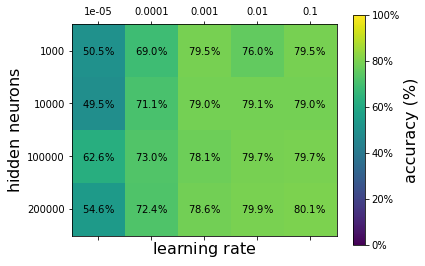

In [57]:
import argparse # handles arguments
import sys; sys.argv=['']; del sys # required to use parser in jupyter notebooks

# Training settings
parser = argparse.ArgumentParser(description='PyTorch SUSY Example')
parser.add_argument('--dataset_size', type=int, default=100000, metavar='DS',
                help='size of data set (default: 100000)')
parser.add_argument('--high_level_feats', type=bool, default=None, metavar='HLF',
                help='toggles high level features (default: None)')
parser.add_argument('--batch-size', type=int, default=100, metavar='N',
                help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.05, metavar='LR',
                help='learning rate (default: 0.02)')
parser.add_argument('--momentum', type=float, default=0.8, metavar='M',
                help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                help='disables CUDA training')
parser.add_argument('--seed', type=int, default=2, metavar='S',
                help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                help='how many batches to wait before logging training status')
args = parser.parse_args()

# set seed of random number generator
torch.manual_seed(args.seed)

grid_search(args)
